# Моделирование вкладов физических лиц

Задача:  требуется построить и описать модель, где целевой переменной (таргетом) являются помесячные изменения объемов рынка вкладов физических лиц РФ в рублях, которая будет объяснима с точки зрения экономической логики.<br> Дополнительно требуется построить прогноз таргета на 1.18 – 12.18.

# Обработка данных

Данные: в файле xls представлены данные по изменениям объемов вкладов физических лиц в рублях в РФ, а также ставки по продукту, связанным с ним продуктам и макроэкономические показатели.

In [1]:
# импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# загружаем данные из файла
data = pd.read_excel('BST_DataSet.xlsx')

In [3]:
data.head()

,Unnamed: 0,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
0,2011-01-01,-79049.0,5.244667,7.75,2.9,4.5,96.29,106.17151,5532900,19307.7,30.08,20669
1,2011-02-01,180475.0,5.144211,8.00,3.1,4.4,103.96,106.99964,5613700,19536.7,29.29,20680
2,2011-03-01,106845.0,5.021364,8.00,3.1,4.2,114.44,107.66304,5647000,19788.7,28.43,22673
3,2011-04-01,224890.0,4.558571,8.00,2.6,4.1,123.15,108.12599,5863400,20020.8,28.10,22519
4,2011-05-01,45856.0,4.795000,8.25,2.6,4.1,114.46,108.64500,5893400,20160.9,27.87,22779


Данные в колонке *M0* и *M2* представлены в разных масштабах(M0 является частью M2,следовательно должно быть меньше),
поэтому приведем М0 к масштабу М2:

In [4]:
# напишем для этого спец. функцию
def transform_M0(data):
    data['М0, руб'] = data['М0, руб']/(1000000)
    return data
data = transform_M0(data)

In [7]:
data[['М0, руб','М2, руб']].head()

,"М0, руб","М2, руб"
0,5.5329,19307.7
1,5.6137,19536.7
2,5.6470,19788.7
3,5.8634,20020.8
4,5.8934,20160.9


Проверим данные на наличие отсутствующих значений

In [8]:
null_series = pd.Series(data.isnull().sum())
display(null_series)

Unnamed: 0                                           0
Прирост вкладов физических лиц в рублях (млн руб)    0
Доходность ОФЗ по сроку до 1 года                    0
Ключевая ставка                                      0
Ставка по вкладам в долларах до 1 года               0
Ставка по вкладам в рублях до 1 года                 0
Нефть марки Юралс, долл./барр                        0
Индекс потребительских цен, ед.                      0
М0, руб                                              0
М2, руб                                              0
Курс доллара к рублю, руб                            0
Номинальная средняя з/п, руб                         0
dtype: int64

Отсутвующих данных нет.<br> Далее посмотрим на корреляцию всех признаков с целевой переменной *Прирост вкладов физических лиц в рублях (млн руб)*

In [9]:
sorted_corrs = data.iloc[:,1:].corr()['Прирост вкладов физических лиц в рублях (млн руб)'].abs().sort_values()
display(sorted_corrs)

Ключевая ставка                                      0.016667
Доходность ОФЗ по сроку до 1 года                    0.017400
Ставка по вкладам в рублях до 1 года                 0.025006
Ставка по вкладам в долларах до 1 года               0.034415
Нефть марки Юралс, долл./барр                        0.068321
Курс доллара к рублю, руб                            0.080033
Индекс потребительских цен, ед.                      0.102976
М2, руб                                              0.146645
М0, руб                                              0.186576
Номинальная средняя з/п, руб                         0.422435
Прирост вкладов физических лиц в рублях (млн руб)    1.000000
Name: Прирост вкладов физических лиц в рублях (млн руб), dtype: float64

Из таблицы видно, что большая часть признаков имеет слабую корреляцию с целевой переменной. Наибольшее значение корреляции
у признаков *Номинальная средняя з/п, М0, М2*
<br>
<br>
Далее посмотрим существует ли корреляция между признаками, для этого воспользуемся тепловой матрицей

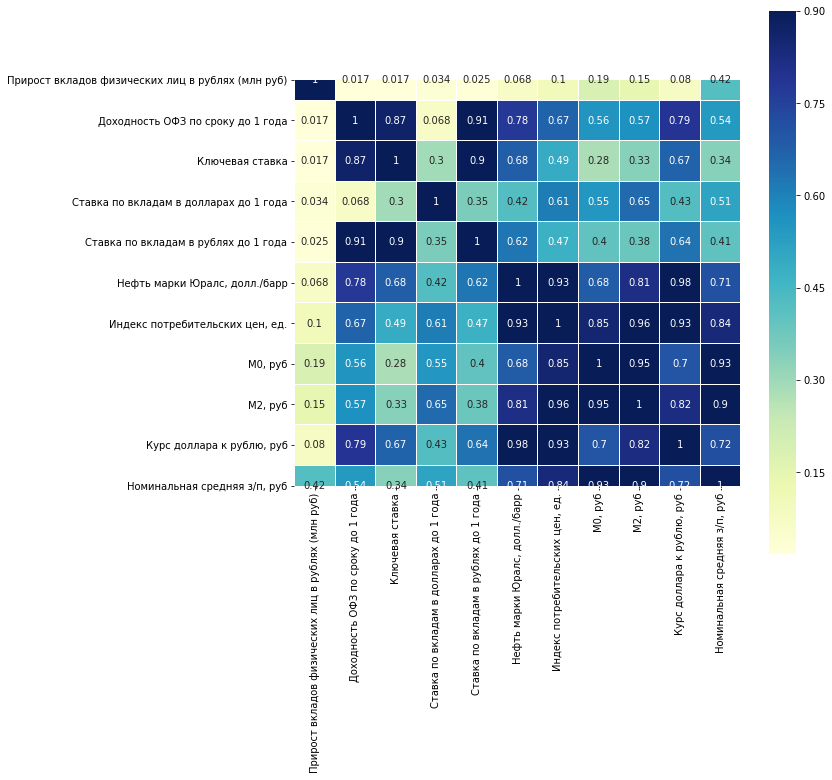

In [10]:
plt.figure(figsize=(10, 10), frameon=True)
sns.heatmap(data.iloc[:,1:].corr().abs(), annot=True, vmax=.9, linewidths=0.01, square=True, cmap='YlGnBu',linecolor="white")
plt.show()

Как видно из теловой карты, некоторые признаки имеют высокую корреляцию с друг другом. <br>Поэтому для улучшения
качества модели из пар признаков с высокой корреляции стоит удалить признак, имеющий меньший показатель с целевой переменной.

In [11]:
# переведем признаки в список и удалим некоторые из них
features = data.columns.to_list()
to_drop = ['Ключевая ставка','Индекс потребительских цен, ед.',
                                       'М2, руб','Доходность ОФЗ по сроку до 1 года','Нефть марки Юралс, долл./барр',
                                        'Unnamed: 0','Прирост вкладов физических лиц в рублях (млн руб)' ]
for i in to_drop:
    features.remove(i)

Так как признаки имеют высокую вариативность, по сравнению с друг другом,стоит их нормализовать.<br>
Для этого воспользуемся модулем preprocessing из библиотеки sklearn

In [12]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [13]:
# для масштабирования и отбора признаков напишем спец. функцию
def transform_df(data):
    x = data.loc[:,features]
    y = data['Прирост вкладов физических лиц в рублях (млн руб)']
    x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=features)
    return x,y

In [14]:
# разделяем данные
X_train, y_train = transform_df(data)

In [15]:
#после нормализации признаки выглядят
X_train.head()

,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"М0, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
0,0.506383,0.060024,0.000000,0.044782,0.000000
1,0.548936,0.048019,0.018192,0.028774,0.000369
2,0.548936,0.024010,0.025689,0.011348,0.067178
3,0.442553,0.012005,0.074411,0.004661,0.062016
4,0.442553,0.012005,0.081165,0.000000,0.070732


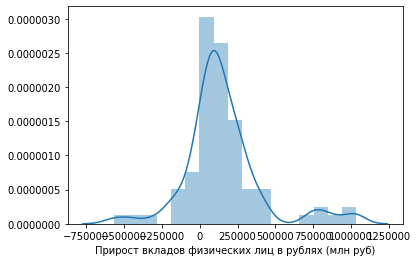

In [16]:
#посмотрим на распределение целевой переменной
sns.distplot(y_train)

Как видно из распределения, целевая переменная имеет распределение, близкое к нормальному.

# Построение модели

Для выбора наилучшей. сравним несколько разных моделей регрессии.
Импортируем их из соответствующих модулей

In [17]:
from sklearn import  linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

Для борьбы с переобучением воспользуемся кросс-валидацией(с количеством фолдов 5).<br>
Для сравнения качества моделей воспользуемся метрикой качества **mean_squared_error(MSE)**
и **root_mean_squared_error(RMSE)**

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

In [20]:
# Результаты по каждой модели поместим в один словарь
scores_map = {}

In [22]:
# Модель линейной регрессии
l_regression = linear_model.LinearRegression()
scores = cross_val_score(l_regression,X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
rmses = np.array([abs(i)**0.5 for i in scores])
scores_map['LinearRegression'] = rmses
print("RMSE: %0.2f (+/- %0.2f)" % (rmses.mean(), rmses.std()))

RMSE: 234850.62 (+/- 64202.13)


In [23]:
# Модель Ридже регрессии
l_ridge = linear_model.Ridge()
scores = cross_val_score(l_ridge, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
rmses = np.array([abs(i)**0.5 for i in scores])
scores_map['RidgeRegression'] = rmses
print("RMSE: %0.2f (+/- %0.2f)" % (rmses.mean(), rmses.std()))

RMSE: 240230.92 (+/- 49887.66)


In [24]:
# Модель регрессии дерева решений
desc_tr = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(desc_tr, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
rmses = np.array([abs(i)**0.5 for i in scores])
scores_map['DecisionTreeRegressor'] = rmses
print("RMSE: %0.2f (+/- %0.2f)" % (rmses.mean(), rmses.std()))

RMSE: 266564.39 (+/- 81211.27)


In [25]:
# Модель регрессии К ближайщих соседей
knn = KNeighborsRegressor(n_neighbors=7)
scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
rmses = np.array([abs(i)**0.5 for i in scores])
scores_map['KNeighborsRegressor'] = rmses
print("RMSE: %0.2f (+/- %0.2f)" % (rmses.mean(), rmses.std()))

RMSE: 239503.89 (+/- 49574.45)


In [26]:
# Модель регрессии градиентного бустинга
gbr = GradientBoostingRegressor()
scores = cross_val_score(gbr, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
rmses = np.array([abs(i)**0.5 for i in scores])
scores_map['GBRegressor'] = rmses
print("RMSE: %0.2f (+/- %0.2f)" % (rmses.mean(), rmses.std()))

RMSE: 209709.04 (+/- 65620.23)


Результаты работы моделей визуализируем с помощью графика бокс плот

Text(0.5, 0, 'Модель')

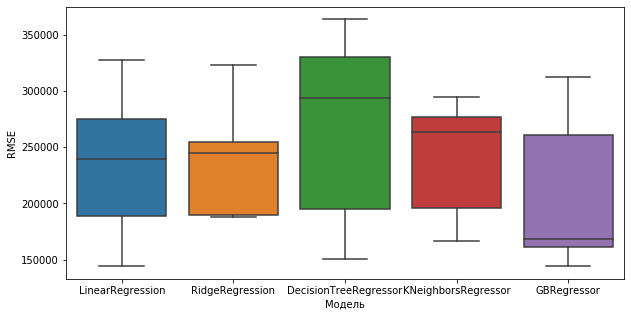

In [27]:
plt.figure(figsize=(10, 5))
scores_map = pd.DataFrame(scores_map)
sns.boxplot(data=scores_map)
plt.ylabel('RMSE')
plt.xlabel('Модель')

Из графика бокс плот следует, что наибольшое качество показали модели Градиентного бустинга и К ближайщих соседей.<br>
Но так как метод К ближайщих соседей является не совсем математической моделью, то для остановимся на модели Градиентного бустинга.<br>
Для подбора параметров модели регрессии Градиентного бустинга, воспользуемся решетчатым поиском

In [28]:
from sklearn.model_selection import GridSearchCV

In [45]:
# подбирать будем параметр n_estimators
param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
model = GradientBoostingRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kf)
grid_result = grid.fit(X_train, y_train)

#выведим лучший показатель метрики RMSE
print("Best: %0.2f using %s" % (abs(grid_result.best_score_)**0.5, grid_result.best_params_))

Best: 217858.80 using {'n_estimators': 400}


In [46]:
#запишем лучший регрессор в переменную
best_reg = grid_result.best_estimator_

# Прогнозирование и оценка качества

Загрузим тестовую выборку и построим предсказание с помощью полученной модели

In [33]:
test_data = pd.read_excel('BST_DataSet_2018.xlsx')
test_data.head()

,Unnamed: 0,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
0,2018-01-01,-453104,6.49,7.75,0.76,5.53,69.7,170.1,8446.0,42442.2,56.49,39017
1,2018-02-01,380519,6.72,7.50,0.72,5.42,65.1,170.5,8163.6,41597.5,56.80,40443
2,2018-03-01,211634,6.30,7.50,0.83,5.43,67.8,171.0,8301.0,42045.5,57.06,42364
3,2018-04-01,450166,6.13,7.25,0.83,5.29,71.6,171.6,8442.6,42377.0,60.76,43381
4,2018-05-01,239,6.57,7.25,1.49,5.39,76.5,172.3,8712.3,43122.0,62.23,44076


In [43]:
# С помощюь уже созданной функции отберем признаки и масштабируем их
X_test, y_test = transform_df(test_data)

In [47]:
# построим прогноз и оценим его качество с помощью MSE и RMSE
from sklearn.metrics import mean_squared_error
predictions = best_reg.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = mse**0.5
print("RMSE: %0.2f " % (rmse))

RMSE: 264380.50 


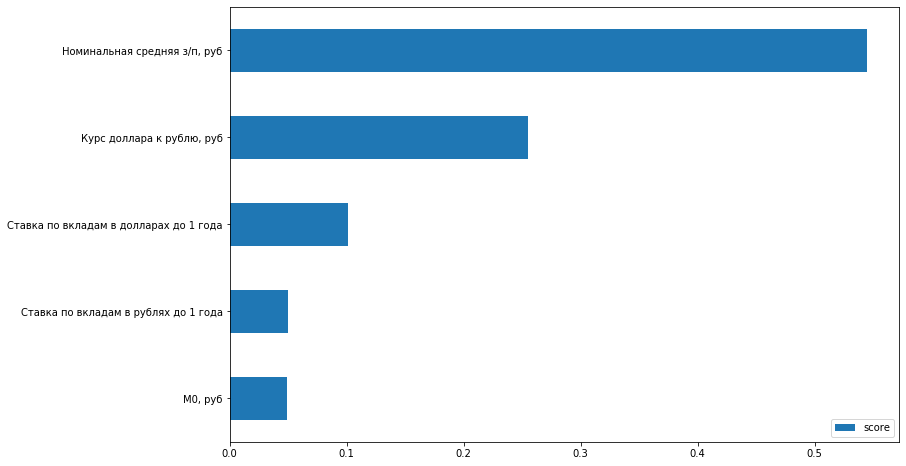

In [49]:
# Посмотрим какие признаки имеили наибольшее влияние на прогноз
features_imp = pd.DataFrame( best_reg.feature_importances_, index=X_train.columns, columns=['score'])
features_imp.sort_values('score').plot(kind='barh', figsize=(12, 8))

# Заключение

После проведенных подбора и построения модели, анализ показал, что наиболее подходящей моделью регрессии
является модель Градиентного бустинга. <br><br>
На тестовой выборке метрика RMSE оказалась выше(264380), чем на обучающей(217858), что говорит о не очень высокой обобщающей способности, причиной которой может быть как недостаточно большой обьем обучающей выборки, так и низкая корреляция 
признаков с целевой переменной.<br>
<br>
Наибольшее влияние на прогноз оказали признаки : *Номинальная средняя з/п*,что логично с экономической точки зрения
(при увеличении з\п увеличивается объем средств, которые люди могут отложить во вклад и наоборот)
и *Ставка по вкдадам*, что так же очевидно(более высокая ставка несет более выгодные условия для вложений и наоборот).
